/var/folders/76/2ttwxdjj1qx_z9ztrhctc3nw0000gp/T/ipykernel_14158/3808777650.py:38: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=sr, mono=True)


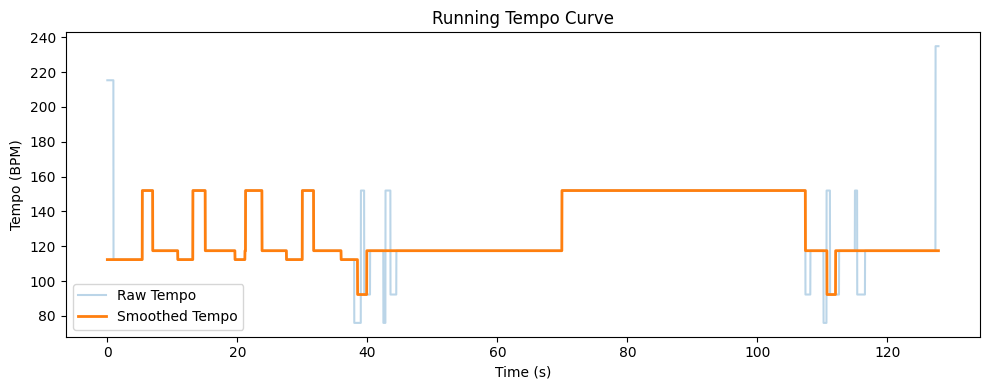

In [5]:
import numpy as np
import librosa
import scipy.signal
import matplotlib.pyplot as plt


def running_tempo(
    audio_path,
    sr=22050,
    hop_length=512,
    start_bpm=120.0,
    max_tempo=300.0,
    smooth_window_sec=3.0,
):
    """
    Compute and plot a running tempo curve for an audio file.

    Parameters
    ----------
    audio_path : str
        Path to the input audio file.
    sr : int
        Sampling rate for audio loading (default: 22050 Hz).
    hop_length : int
        Hop length in samples between successive frames (default: 512).
    start_bpm : float
        Initial tempo guess for dynamic estimation (default: 120 BPM).
    max_tempo : float
        Maximum tempo to consider in BPM (default: 300 BPM).
    smooth_window_sec : float
        Window length in seconds for median smoothing (default: 1 s).

    Returns
    -------
    times : np.ndarray
        Time (in seconds) for each tempo estimate.
    tempo_smooth : np.ndarray
        Smoothed tempo curve (BPM) over time.
    """
    # 1. Load audio as mono float32, resampled to sr
    y, sr = librosa.load(audio_path, sr=sr, mono=True)

    # 2. Compute spectral‐flux onset strength envelope
    onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)

    # 3. Estimate dynamic tempo per frame (BPM array)
    tempo_series = librosa.feature.rhythm.tempo(
        onset_envelope=onset_env,
        sr=sr,
        hop_length=hop_length,
        start_bpm=start_bpm,
        aggregate=None,
        max_tempo=max_tempo,
    )

    # 4. Map frame indices to time (seconds)
    frames = np.arange(len(tempo_series))
    times = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)

    # 5. Smooth the tempo curve with a median filter
    smooth_kernel = int(np.round(smooth_window_sec * sr / hop_length))
    if smooth_kernel % 2 == 0:
        smooth_kernel += 1  # ensure kernel size is odd
    tempo_smooth = scipy.signal.medfilt(tempo_series, kernel_size=smooth_kernel)

    # 6. Plot the running tempo curve
    plt.figure(figsize=(10, 4))
    plt.plot(times, tempo_series, alpha=0.3, label="Raw Tempo")
    plt.plot(times, tempo_smooth, linewidth=2, label="Smoothed Tempo")
    plt.xlabel("Time (s)")
    plt.ylabel("Tempo (BPM)")
    plt.title("Running Tempo Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return times, tempo_smooth


times, tempo_curve = running_tempo("../audio/spiderdance audio.mp4")